In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats

In [2]:
dowjones = pd.read_csv('weekly dowjones Trading Strategy v2.csv')
dowjones.head(10)

,TICKER,date,SICCD,COMNAM,market_cap,SHROUT,VOL,PRC,ASKHI,BIDLO,...,comp_size,dummy_negative,dummy_positive,dummy_total,move_avg_2,move_avg_3,move_avg_4,lasso_pred,pred_forest,log_pred
0,AAPL,2023-01-30,3571,APPLE INC,-1.677700,1.354988,0.416489,-1.676230,-1.701180,-1.697687,...,9,0,0,1,0,0,0,0.010249,0.030461,Positive
1,AAPL,2023-02-06,3571,APPLE INC,-1.319746,1.354988,3.029032,-1.338162,-1.107388,-1.555682,...,9,0,0,1,0,0,0,0.006408,0.019047,Positive
2,AAPL,2023-02-13,3571,APPLE INC,-1.131240,1.354988,0.453799,-1.160129,-1.233166,-1.108736,...,9,0,0,1,0,0,0,0.011168,0.011429,Positive
3,AAPL,2023-02-20,3571,APPLE INC,-1.056134,1.354988,0.377910,-1.089196,-1.168814,-1.016517,...,9,0,0,1,0,0,0,0.011856,0.011429,Positive
4,AAPL,2023-02-27,3571,APPLE INC,-1.384685,1.354988,-0.473141,-1.399493,-1.463078,-1.306739,...,9,1,1,1,1,1,0,0.003097,0.027459,Positive
5,AAPL,2023-03-06,3571,APPLE INC,-1.359559,1.354988,0.346285,-1.375763,-1.170569,-1.409718,...,9,0,0,0,0,0,0,0.008589,-0.020737,Positive
6,AAPL,2023-03-13,3571,APPLE INC,-1.231622,1.354988,0.247243,-1.254934,-1.273825,-1.199845,...,9,0,1,1,0,0,0,0.013802,0.034940,Positive
7,AAPL,2023-03-20,3571,APPLE INC,-0.991286,1.354988,1.661683,-1.027951,-1.081646,-1.069133,...,9,0,0,1,0,0,0,0.006305,0.019047,Positive
8,AAPL,2023-03-27,3571,APPLE INC,-0.739541,1.354988,0.557649,-0.790192,-0.828919,-0.694604,...,9,0,0,0,0,0,0,0.012291,0.011429,Positive
9,AAPL,2023-04-03,3571,APPLE INC,-0.554821,0.969297,-0.352356,-0.592097,-0.586138,-0.726285,...,9,0,0,1,0,0,0,0.004918,0.000848,Positive


In [3]:
dowjones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TICKER            1348 non-null   object 
 1   date              1348 non-null   object 
 2   SICCD             1348 non-null   int64  
 3   COMNAM            1348 non-null   object 
 4   market_cap        1348 non-null   float64
 5   SHROUT            1348 non-null   float64
 6   VOL               1348 non-null   float64
 7   PRC               1348 non-null   float64
 8   ASKHI             1348 non-null   float64
 9   BIDLO             1348 non-null   float64
 10  total             1348 non-null   int64  
 11  negative          1348 non-null   int64  
 12  positive          1348 non-null   int64  
 13  sprtrn            1348 non-null   float64
 14  RET               1348 non-null   float64
 15  next_week_return  1348 non-null   float64
 16  last_week_return  1348 non-null   float64


In [4]:
# Change date column to datetime with %Y-%m-%d format
dowjones['date'] = pd.to_datetime(dowjones['date'], format='%Y-%m-%d')

# Change SICCD column to object
dowjones['SICCD'] = dowjones['SICCD'].astype(str)

# Change proper. column to object
dowjones['proper'] = dowjones['proper'].astype(str)

# Print the updated DataFrame info to verify the changes
print(dowjones.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   TICKER            1348 non-null   object        
 1   date              1348 non-null   datetime64[ns]
 2   SICCD             1348 non-null   object        
 3   COMNAM            1348 non-null   object        
 4   market_cap        1348 non-null   float64       
 5   SHROUT            1348 non-null   float64       
 6   VOL               1348 non-null   float64       
 7   PRC               1348 non-null   float64       
 8   ASKHI             1348 non-null   float64       
 9   BIDLO             1348 non-null   float64       
 10  total             1348 non-null   int64         
 11  negative          1348 non-null   int64         
 12  positive          1348 non-null   int64         
 13  sprtrn            1348 non-null   float64       
 14  RET               1348 n

In [5]:
import pandas as pd
from scipy.stats import ttest_ind

# Drop rows with NaN values in 'next_week_return' column
dowjones.dropna(subset=['next_week_return'], inplace=True)

# Select only numeric columns
numeric_columns = dowjones.select_dtypes(include=['int64', 'float64'])

# Create subsets
positive_return = numeric_columns[dowjones['next_week_return'] >= 0]
negative_return = numeric_columns[dowjones['next_week_return'] < 0]

# Calculate mean for each subset
mean_positive_return = positive_return.mean()
mean_negative_return = negative_return.mean()

# Calculate mean difference
mean_diff = mean_positive_return - mean_negative_return

# Perform t-test for mean difference
t_stat, p_value = ttest_ind(positive_return, negative_return, equal_var=False)

# Create a DataFrame to store the results
result_df = pd.DataFrame(index=numeric_columns.columns)
result_df['negative_next_week_return'] = mean_negative_return
result_df['mean_positive_next_week_return'] = mean_positive_return
result_df['mean_difference'] = mean_diff
result_df['p_value'] = p_value

# Set pandas display options to suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Print the result DataFrame
print(result_df)

                  negative_next_week_return  mean_positive_next_week_return  \
market_cap                            0.148                          -0.104   
SHROUT                                0.010                          -0.086   
VOL                                   0.004                           0.022   
PRC                                   0.147                          -0.101   
ASKHI                                 0.150                          -0.104   
BIDLO                                 0.136                          -0.095   
total                                 4.190                           4.028   
negative                              0.039                           0.041   
positive                              0.635                           0.637   
sprtrn                               -0.006                          -0.062   
RET                                  -0.002                          -0.003   
next_week_return                     -0.021         

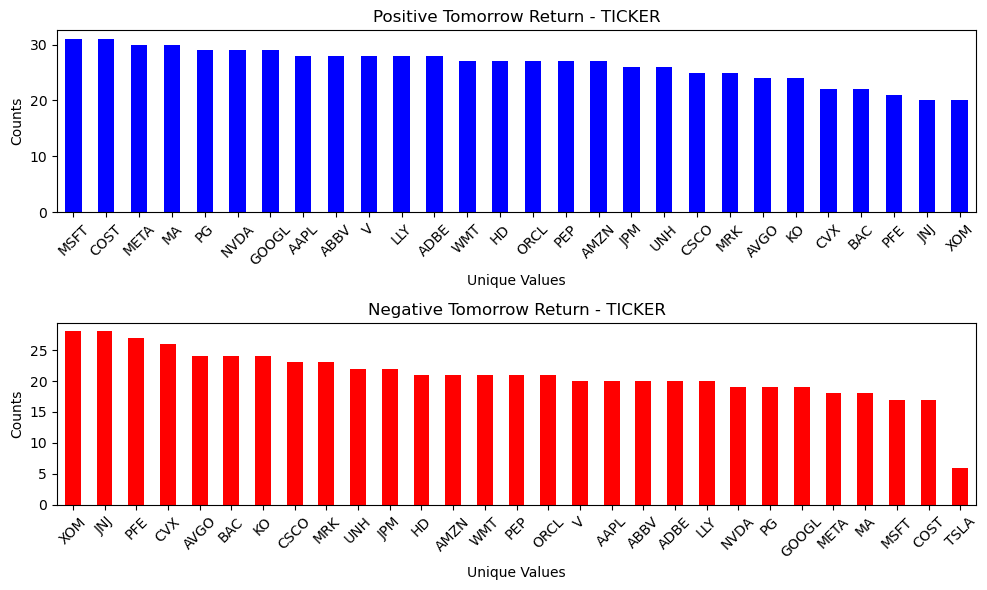

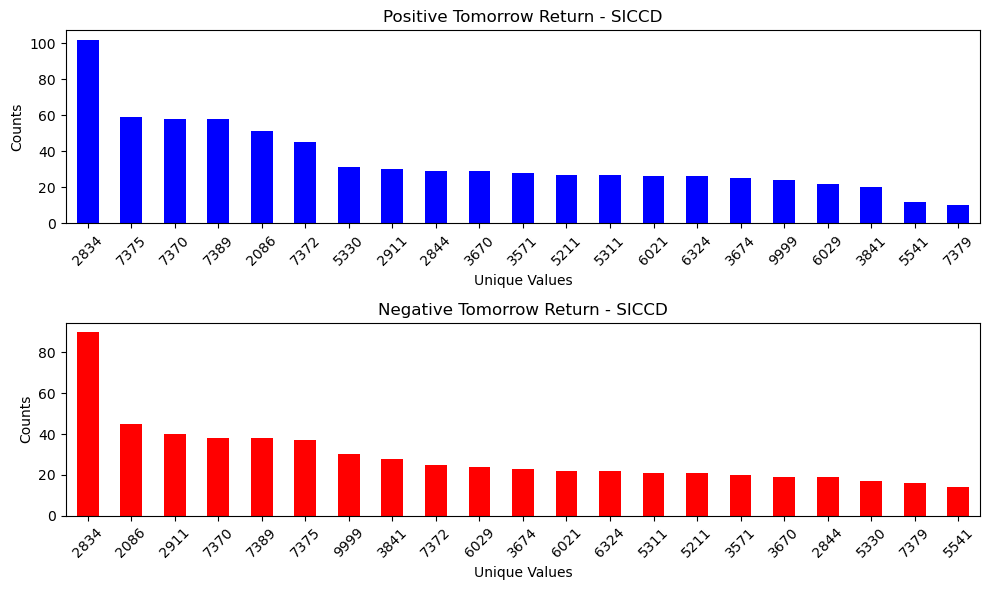

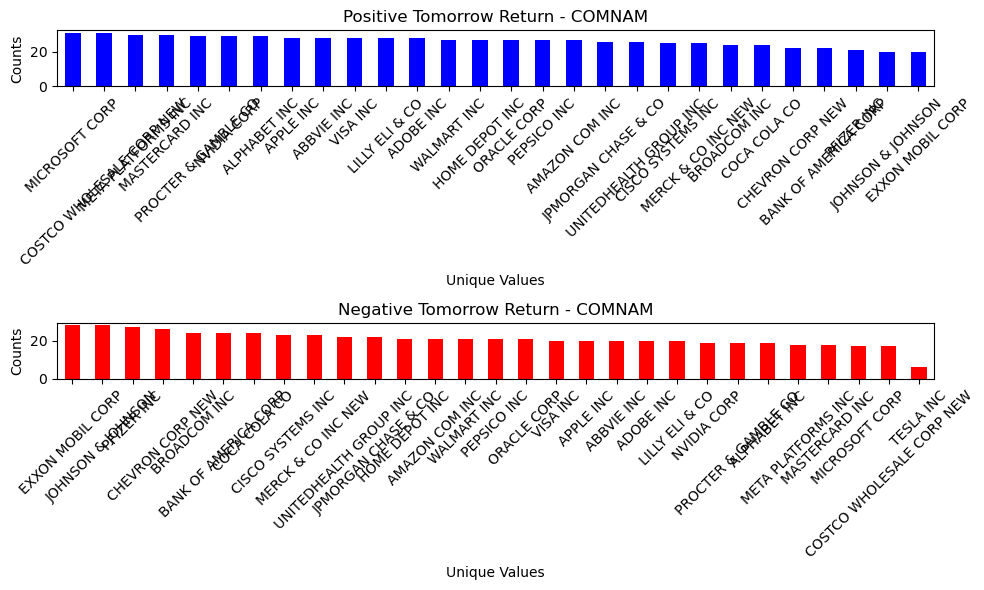

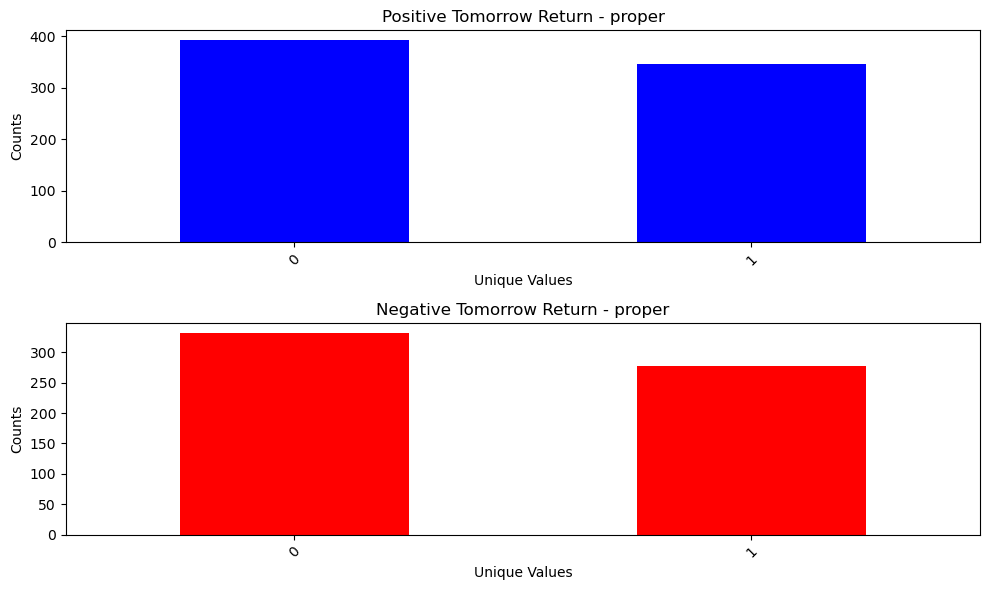

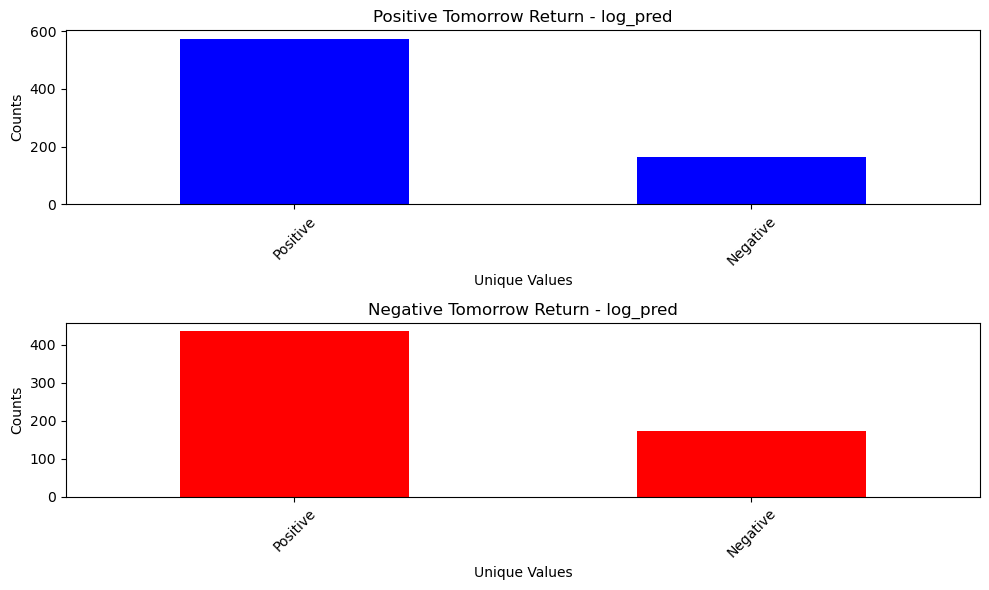

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Drop rows with NaN values in 'next_week_return' column
dowjones.dropna(subset=['next_week_return'], inplace=True)

# Select only categorical columns
categorical_columns = dowjones.select_dtypes(include=['object'])

# Create subsets
positive_return = dowjones[dowjones['next_week_return'] >= 0]
negative_return = dowjones[dowjones['next_week_return'] < 0]

# Plot bar charts for each unique value in categorical columns
for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    
    # Positive return subset
    plt.subplot(2, 1, 1)
    positive_counts = positive_return[column].value_counts()
    positive_counts.plot(kind='bar', color='blue')
    plt.title(f'Positive Tomorrow Return - {column}')
    plt.xlabel('Unique Values')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    
    # Negative return subset
    plt.subplot(2, 1, 2)
    negative_counts = negative_return[column].value_counts()
    negative_counts.plot(kind='bar', color='red')
    plt.title(f'Negative Tomorrow Return - {column}')
    plt.xlabel('Unique Values')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

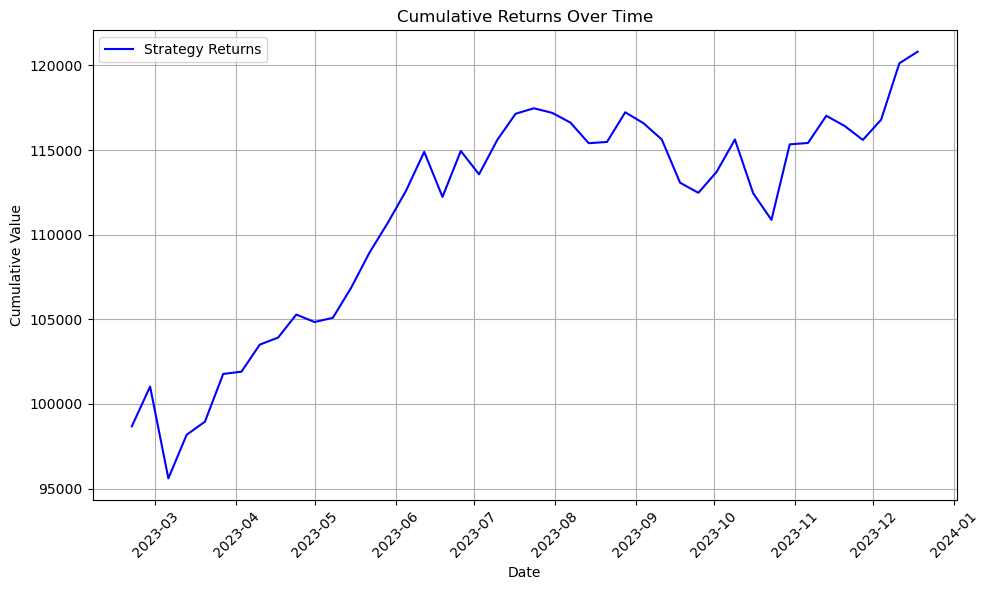

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy.loc[(dowjones_copy['total'] > 2), 'position'] = 1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


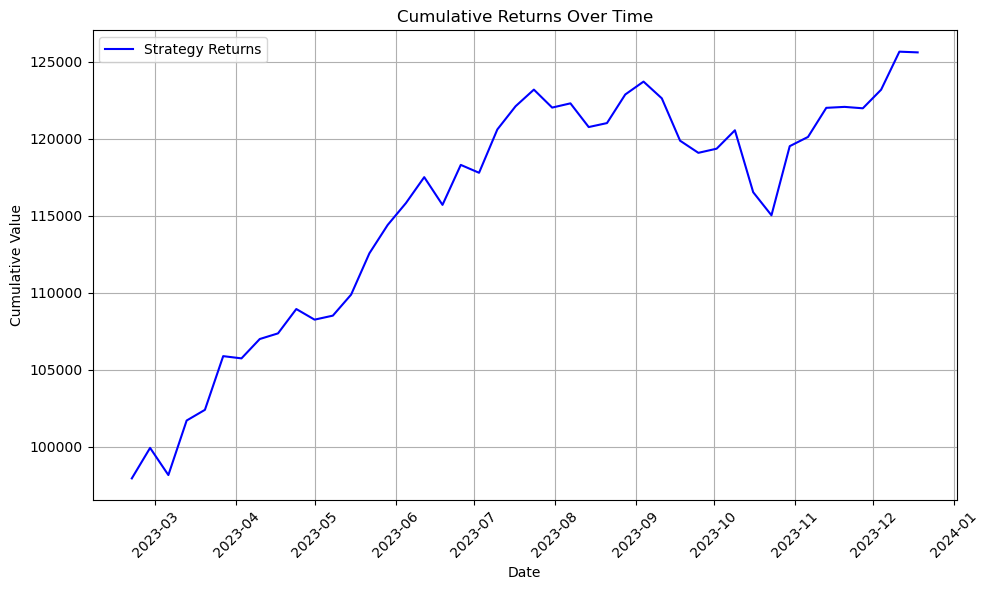

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['lasso_pred'] > 0), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['lasso_pred'] < 0), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


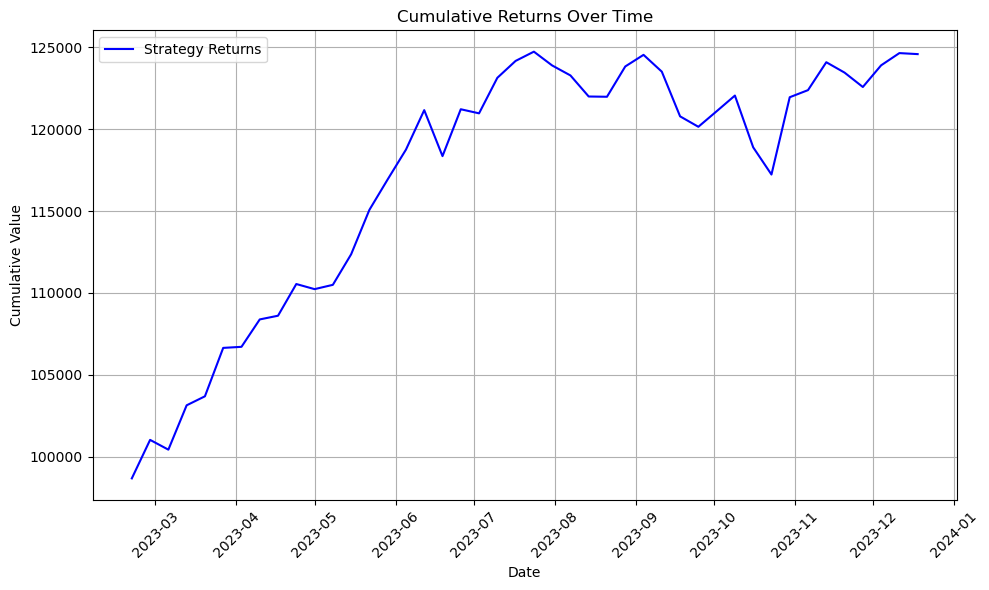

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['lasso_pred'] > 0) & (dowjones_copy['total'] > 2), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['lasso_pred'] < 0) & (dowjones_copy['total'] > 2), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


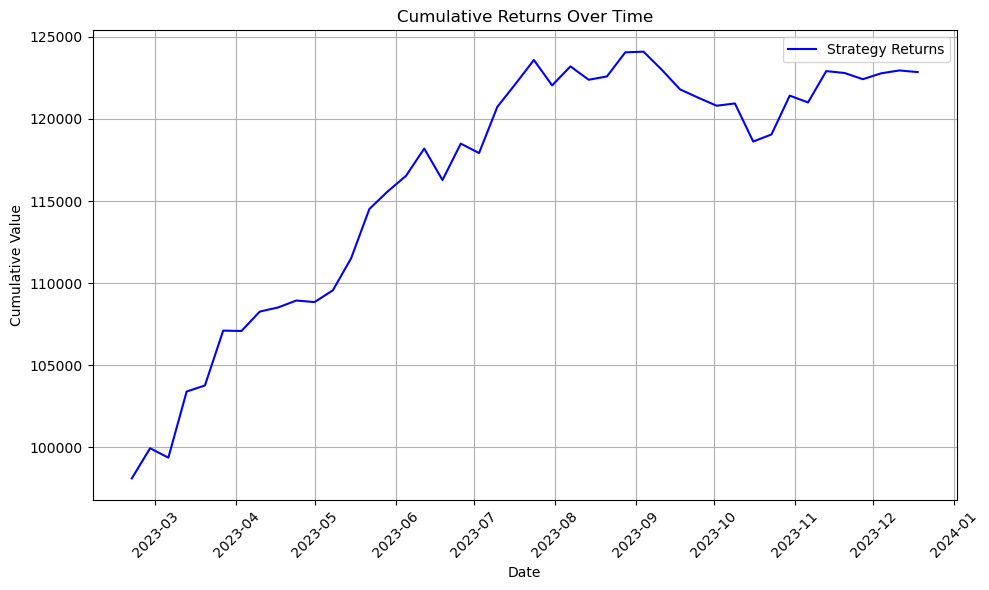

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['log_pred'] == 'Positive'), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['log_pred'] == 'Negative'), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


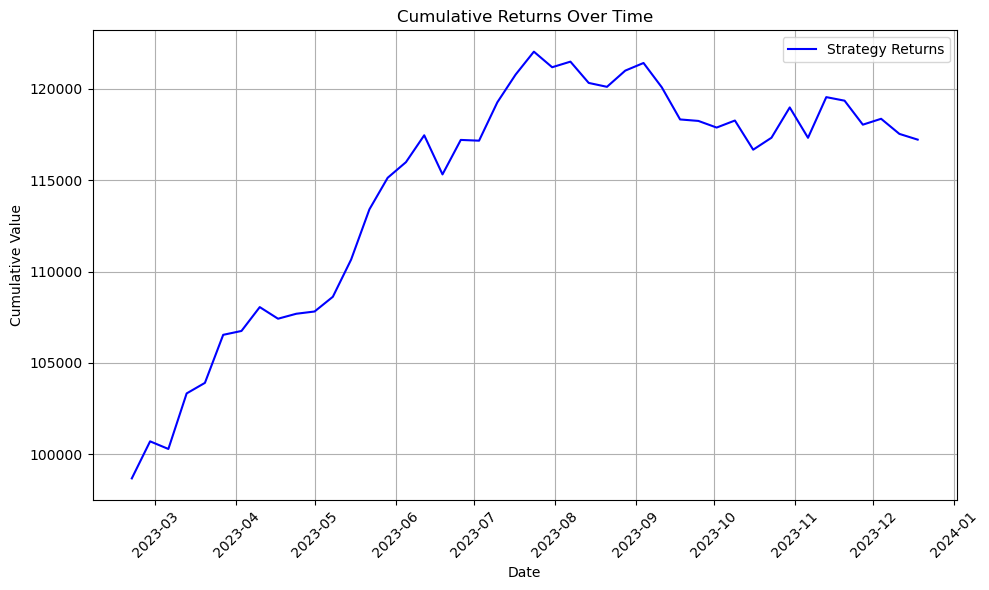

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['log_pred'] == 'Positive') & (dowjones_copy['total'] > 2), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['log_pred'] == 'Negative') & (dowjones_copy['total'] > 2), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


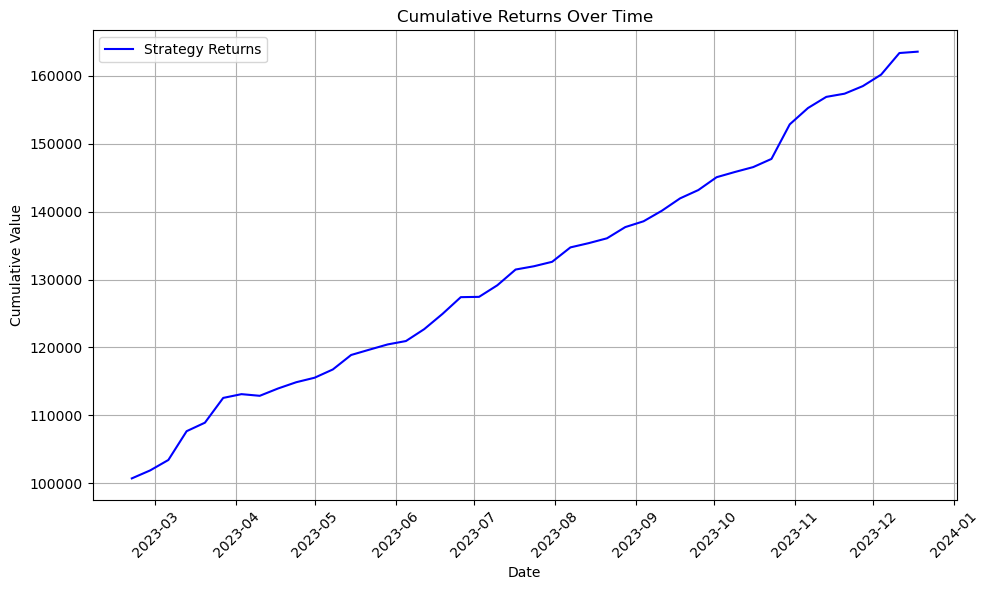

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['pred_forest'] > 0), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['pred_forest'] < 0), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


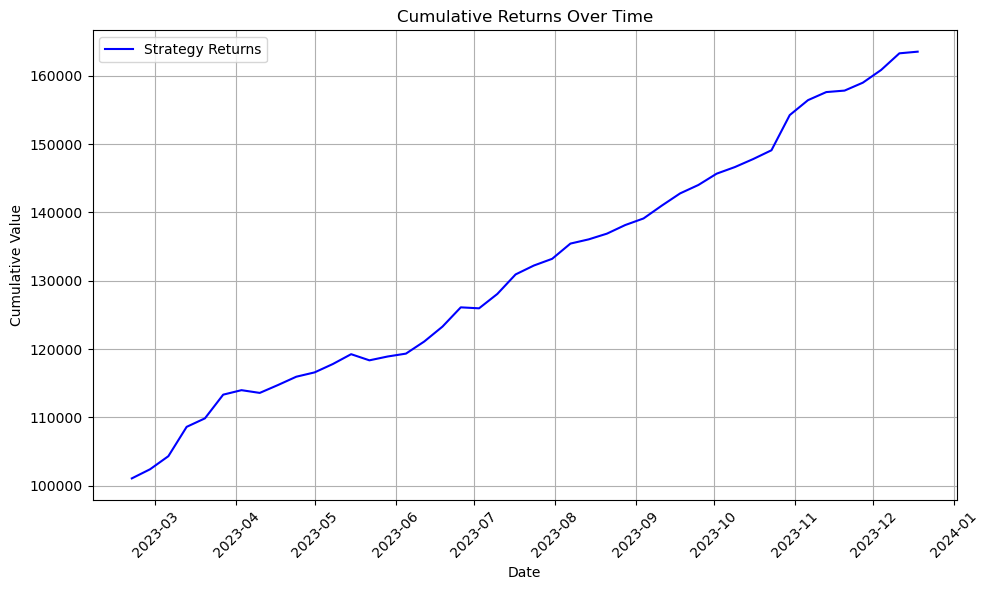

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['pred_forest'] > 0) & (dowjones_copy['dummy_total'] == 1), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['pred_forest'] < 0) & (dowjones_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


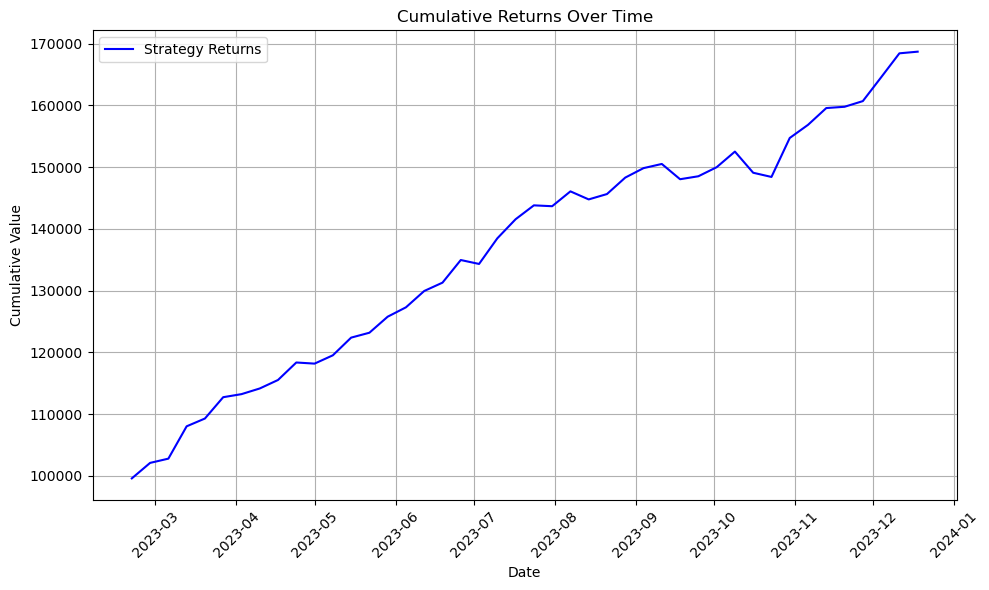

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['pred_forest'] > 0) & (dowjones_copy['lasso_pred'] > 0) & (dowjones_copy['dummy_total'] == 1), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['pred_forest'] < 0) & (dowjones_copy['lasso_pred'] < 0) & (dowjones_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


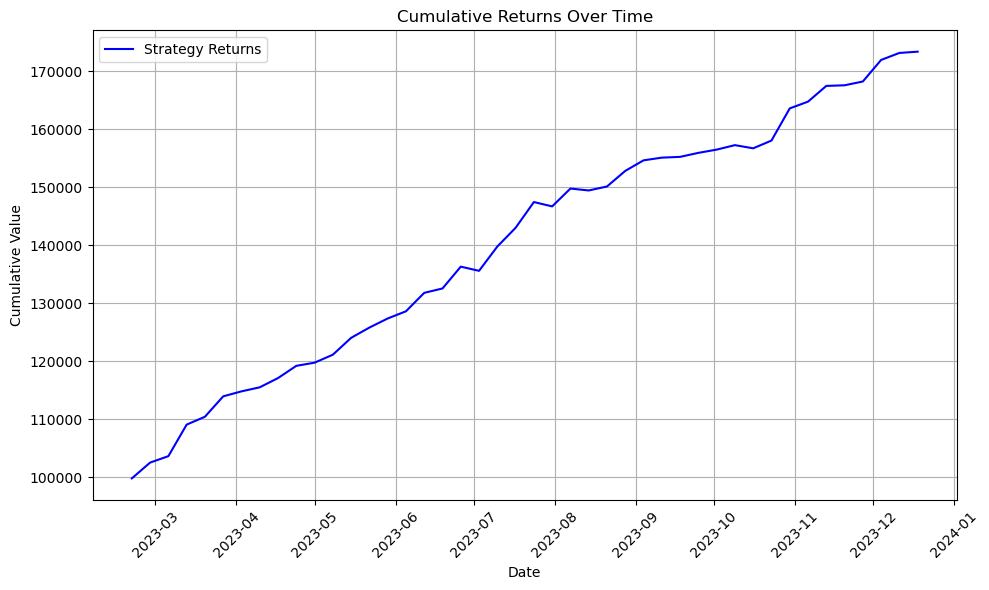

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['pred_forest'] > 0) & (dowjones_copy['log_pred'] == 'Positive') & (dowjones_copy['dummy_total'] == 1), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['pred_forest'] < 0) & (dowjones_copy['log_pred'] == 'Negative') & (dowjones_copy['dummy_total'] == 1), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


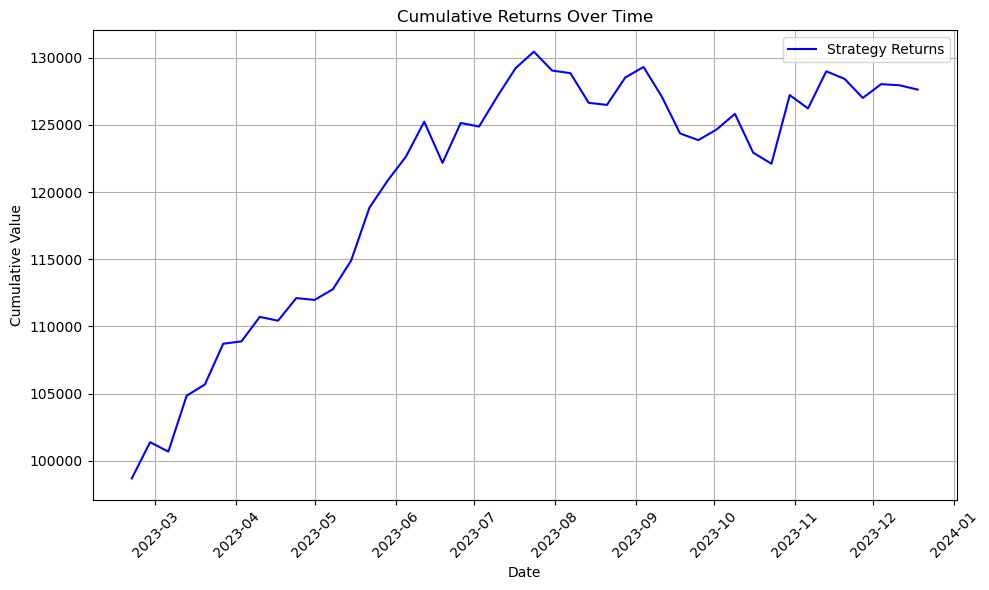

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['log_pred'] == 'Positive') & (dowjones_copy['lasso_pred'] > 0) & (dowjones_copy['total'] > 2), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['log_pred'] == 'Negative') & (dowjones_copy['lasso_pred'] < 0) & (dowjones_copy['total'] > 2), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


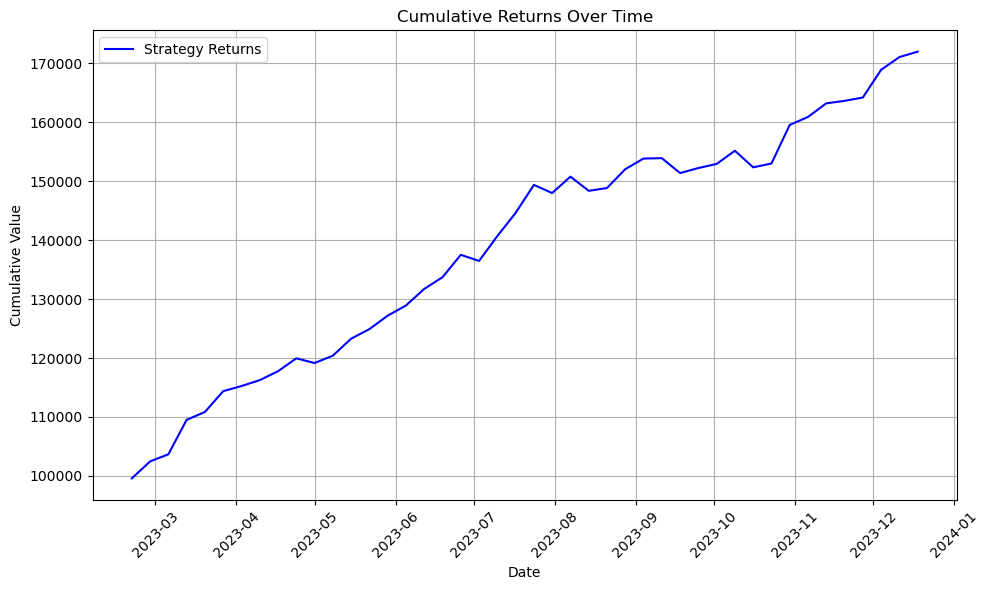

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a copy of the original DataFrame
dowjones_copy = dowjones.copy()

# Convert 'date' column to datetime format
dowjones_copy['date'] = pd.to_datetime(dowjones_copy['date'], format='%Y-%m-%d')

# Filter data to include dates after February 13, 2023
dowjones_copy = dowjones_copy[dowjones_copy['date'] > '2023-02-13']

# Create a new column 'position' based on the conditions
dowjones_copy['position'] = 0
dowjones_copy.loc[(dowjones_copy['pred_forest'] > 0) & (dowjones_copy['lasso_pred'] > 0) & (dowjones_copy['dummy_total'] == 1) & (dowjones_copy['log_pred'] == 'Positive'), 'position'] = 1
dowjones_copy.loc[(dowjones_copy['pred_forest'] < 0) & (dowjones_copy['lasso_pred'] < 0) & (dowjones_copy['dummy_total'] == 1) & (dowjones_copy['log_pred'] == 'Negative'), 'position'] = -1

# Initialize initial investment amount for the strategy
initial_investment = 100000
# Initialize a list to store cumulative values for the strategy
cumulative_values = [initial_investment]

# Calculate weekly mode of 'sprtrn' for S&P 500
weekly_mode_sprtrn = dowjones_copy.groupby('date')['sprtrn'].apply(lambda x: x.mode().iloc[0]).reset_index()

# Initialize initial investment amount for S&P 500
initial_investment_sp500 = 100000
# Initialize a list to store cumulative values for S&P 500
cumulative_values_sp500 = [initial_investment_sp500]

# Iterate over each unique date
unique_dates = dowjones_copy['date'].unique()
for i in range(len(unique_dates) - 1):
    # Filter data for the current date for the strategy
    current_date_data = dowjones_copy[dowjones_copy['date'] == unique_dates[i]]
    # Filter data for the current date for S&P 500
    current_date_sprtrn = weekly_mode_sprtrn[weekly_mode_sprtrn['date'] == unique_dates[i]]
    
    # Count the number of companies with positions of 1 or -1 for the current date for the strategy
    num_pos_1 = (current_date_data['position'] == 1).sum()
    num_neg_1 = (current_date_data['position'] == -1).sum()
    
    # Calculate investment per company for the current date for the strategy
    investment_per_company = cumulative_values[-1] / (num_pos_1 + num_neg_1)
    
    # Calculate strategy return for each company for the current date
    strategy_returns = current_date_data['position'] * current_date_data['next_week_return'] * investment_per_company
    
    # Sum up the returns for all companies for the current date for the strategy
    total_returns = strategy_returns.sum()
    
    # Append cumulative value for the next date for the strategy
    cumulative_values.append(cumulative_values[-1] + total_returns)
    

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(unique_dates[:-1], cumulative_values[1:], label='Strategy Returns', color='blue')
plt.xlabel('Date')
plt.ylabel('Cumulative Value')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
